In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import  nltk.translate.bleu_score as bleu

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

In [3]:
# Maximum number of samples to preprocess
# MAX_SAMPLES = 5000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
#   sentence = '<start> ' + sentence + ' <end>'
  return sentence


def load_conversations(num1,num2):
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines[num1:num2]:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
#       if len(inputs) >= MAX_SAMPLES:
#         return inputs, outputs
  return inputs, outputs


questions, answers = load_conversations(0,20000)

In [4]:
len(questions),len(answers)

(53430, 53430)

In [5]:
questions_val, answers_val = load_conversations(80001,80500)

In [6]:
len(questions_val),len(answers_val)

(1634, 1634)

In [7]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i can t . not unless my sister goes .
Sample answer: i m workin on it . but she doesn t seem to be goin for him .


In [8]:
# Build tokenizer using tfds for both questions and answers
tokenizer_ques = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions, target_vocab_size=2**13)

tokenizer_ans = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    answers, target_vocab_size=2**13)

# Build tokenizer using tfds for both questions and answers
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     questions + answers, target_vocab_size=2**13)



In [9]:
# # Define start and end token to indicate the start and end of a sentence
# START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# # Vocabulary size plus start and end token
# VOCAB_SIZE = tokenizer.vocab_size + 2

In [10]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_ques.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_ques.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7769, 5323, 6016, 19, 4384, 1154, 7731]
The original string: Transformer is awesome.


In [11]:
sample_string = questions[20]

tokenized_string = tokenizer_ques.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_ques.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [4, 303, 2, 303, 2, 144, 426, 185, 2, 44, 4, 38, 7801, 3, 42, 1062, 31, 1766, 3469, 1]
The original string: i really , really , really wanna go , but i can t . not unless my sister goes .


In [12]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_ques.decode([ts])))

4 ----> i 
303 ----> really
2 ---->  , 
303 ----> really
2 ---->  , 
144 ----> really 
426 ----> wanna 
185 ----> go
2 ---->  , 
44 ----> but 
4 ----> i 
38 ----> can 
7801 ----> t
3 ---->  . 
42 ----> not 
1062 ----> unless 
31 ----> my 
1766 ----> sister 
3469 ----> goes
1 ---->  .


In [13]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [14]:
def encode(lang1, lang2):
  lang1 = [tokenizer_ques.vocab_size] + tokenizer_ques.encode(
      lang1.numpy()) + [tokenizer_ques.vocab_size+1]

  lang2 = [tokenizer_ans.vocab_size] + tokenizer_ans.encode(
      lang2.numpy()) + [tokenizer_ans.vocab_size+1]
  
  return lang1, lang2

In [15]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [16]:
MAX_LENGTH = 40

In [17]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [18]:
train_preprocessed = (
    tf.data.Dataset.from_tensor_slices((questions, answers))
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

# val_preprocessed = (
#     tf.data.Dataset.from_tensor_slices((questions_val, answers_val))
#     .map(tf_encode)
#     .filter(filter_max_length))     

In [19]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

# val_dataset = (val_preprocessed
#                .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [20]:
# print('Tokenized sample question: {}'.format(tokenizer_ques.encode(questions[20])))

In [21]:
# # Maximum sentence length
# MAX_LENGTH = 40


# # Tokenize, filter and pad sentences
# def tokenize_and_filter(inputs, outputs):
#   tokenized_inputs, tokenized_outputs = [], []
  
#   for (sentence1, sentence2) in zip(inputs, outputs):
#     # tokenize sentence
#     sentence1 = [tokenizer_ques.vocab_size] + tokenizer_ques.encode(sentence1) + [tokenizer_ques.vocab_size + 1]
#     sentence2 = [tokenizer_ans.vocab_size] + tokenizer_ans.encode(sentence2) + [tokenizer_ans.vocab_size + 1]
#     # check tokenized sentence max length
#     if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
#       tokenized_inputs.append(sentence1)
#       tokenized_outputs.append(sentence2)
  
#   # pad tokenized sentences
#   tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
#   tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
#   return tokenized_inputs, tokenized_outputs


# questions, answers = tokenize_and_filter(questions, answers)

In [22]:
# questions[20]

In [23]:
# answers[20]

In [24]:
# print('Vocab size: {}'.format(VOCAB_SIZE))
# print('Number of samples: {}'.format(len(questions)))

In [25]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 20000

# # decoder inputs use the previous target as input
# # remove START_TOKEN from targets
# # dataset = tf.data.Dataset.from_tensor_slices((
# #     {
# #         'inputs': questions
# #         #'dec_inputs': answers[:, :-1]
# #     },
# #     {
# #         'outputs': answers
# #     },
# # ))
# dataset = tf.data.Dataset.from_tensor_slices((questions, answers))
# dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
print(train_dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>


In [27]:
ques_batch, ans_batch = next(iter(train_dataset))
ques_batch

<tf.Tensor: shape=(64, 31), dtype=int64, numpy=
array([[7941,   16,   30, ...,    0,    0,    0],
       [7941,   42,   83, ...,    0,    0,    0],
       [7941,  311,    2, ...,    0,    0,    0],
       ...,
       [7941,    5,   50, ...,    0,    0,    0],
       [7941,   30,    5, ...,    0,    0,    0],
       [7941,  113, 1492, ...,    0,    0,    0]], dtype=int64)>

In [28]:
ans_batch

<tf.Tensor: shape=(64, 40), dtype=int64, numpy=
array([[8025,  313,    3, ...,    0,    0,    0],
       [8025,    4,  280, ...,    0,    0,    0],
       [8025,   55,    2, ...,    0,    0,    0],
       ...,
       [8025,   74,    1, ...,    0,    0,    0],
       [8025,   17,   31, ...,    0,    0,    0],
       [8025,    4,  109, ...,    0,    0,    0]], dtype=int64)>

# Positional Encoding 

In [29]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [30]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


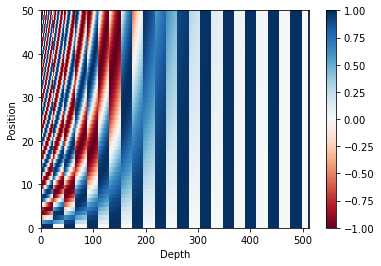

In [31]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Masking

In [32]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [33]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [34]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [35]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled Dot Product Attention

In [36]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [37]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [38]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [39]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [40]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [41]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# Multi-head attention

In [42]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [43]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point Wise Feed Forward Network

In [44]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [45]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoder and Decoder

In [46]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [47]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [48]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [49]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Encoder

In [50]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [51]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# Decoder

In [52]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [53]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Create The Transformer

In [54]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [55]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Set Hyperparameters

In [56]:
num_layers = 6
d_model = 512
dff = 1024
num_heads = 8

input_vocab_size = tokenizer_ques.vocab_size + 2 #questions.vocab_size #+ 2
target_vocab_size = tokenizer_ans.vocab_size + 2 #answers.vocab_size #+ 2
dropout_rate = 0.1

# Optimizer

In [57]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [58]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

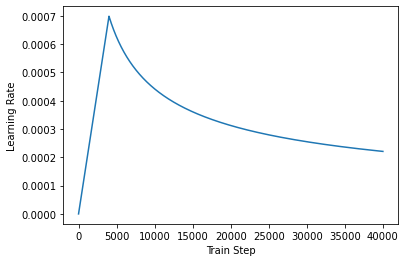

In [59]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and Metrics

In [60]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [61]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [62]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Training and Checkpointing

In [63]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [64]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [65]:
checkpoint_path = "./checkpoints/train_transformer2"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [66]:
EPOCHS = 20

In [67]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [68]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0529 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7455 Accuracy 0.0141
Epoch 1 Batch 100 Loss 8.4174 Accuracy 0.0207
Epoch 1 Batch 150 Loss 8.1518 Accuracy 0.0230
Epoch 1 Batch 200 Loss 7.8926 Accuracy 0.0241
Epoch 1 Batch 250 Loss 7.6216 Accuracy 0.0248
Epoch 1 Batch 300 Loss 7.3558 Accuracy 0.0280
Epoch 1 Batch 350 Loss 7.1427 Accuracy 0.0308
Epoch 1 Batch 400 Loss 6.9701 Accuracy 0.0333
Epoch 1 Batch 450 Loss 6.8248 Accuracy 0.0360
Epoch 1 Batch 500 Loss 6.6910 Accuracy 0.0388
Epoch 1 Batch 550 Loss 6.5651 Accuracy 0.0416
Epoch 1 Batch 600 Loss 6.4485 Accuracy 0.0442
Epoch 1 Batch 650 Loss 6.3399 Accuracy 0.0466
Epoch 1 Batch 700 Loss 6.2451 Accuracy 0.0488
Epoch 1 Loss 6.1854 Accuracy 0.0501
Time taken for 1 epoch: 157.67848873138428 secs

Epoch 2 Batch 0 Loss 4.7804 Accuracy 0.0701
Epoch 2 Batch 50 Loss 4.8883 Accuracy 0.0807
Epoch 2 Batch 100 Loss 4.8737 Accuracy 0.0802
Epoch 2 Batch 150 Loss 4.8471 Accuracy 0.0801
Epoch 2 Batch 200 Loss 4.8270 Accuracy 0.0797
E

Epoch 11 Batch 350 Loss 4.1341 Accuracy 0.0921
Epoch 11 Batch 400 Loss 4.1344 Accuracy 0.0921
Epoch 11 Batch 450 Loss 4.1328 Accuracy 0.0922
Epoch 11 Batch 500 Loss 4.1333 Accuracy 0.0922
Epoch 11 Batch 550 Loss 4.1315 Accuracy 0.0924
Epoch 11 Batch 600 Loss 4.1317 Accuracy 0.0924
Epoch 11 Batch 650 Loss 4.1327 Accuracy 0.0923
Epoch 11 Batch 700 Loss 4.1369 Accuracy 0.0923
Epoch 11 Loss 4.1390 Accuracy 0.0925
Time taken for 1 epoch: 134.19644331932068 secs

Epoch 12 Batch 0 Loss 4.1087 Accuracy 0.0933
Epoch 12 Batch 50 Loss 4.1093 Accuracy 0.0918
Epoch 12 Batch 100 Loss 4.1025 Accuracy 0.0925
Epoch 12 Batch 150 Loss 4.0980 Accuracy 0.0926
Epoch 12 Batch 200 Loss 4.0953 Accuracy 0.0930
Epoch 12 Batch 250 Loss 4.0970 Accuracy 0.0931
Epoch 12 Batch 300 Loss 4.0939 Accuracy 0.0933
Epoch 12 Batch 350 Loss 4.0910 Accuracy 0.0935
Epoch 12 Batch 400 Loss 4.0921 Accuracy 0.0935
Epoch 12 Batch 450 Loss 4.0916 Accuracy 0.0934
Epoch 12 Batch 500 Loss 4.0912 Accuracy 0.0935
Epoch 12 Batch 550 Loss 

# Evaluate

In [69]:
def evaluate(inp_sentence):
  start_token = [tokenizer_ques.vocab_size]
  end_token = [tokenizer_ques.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_ques.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_ans.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_ans.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [70]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_ques.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_ques.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_ans.decode([i]) for i in result 
                        if i < tokenizer_ans.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [71]:
def chatbot(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_ans.decode([i for i in result 
                                            if i < tokenizer_ans.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted Response: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)
    
  return predicted_sentence

Input: Yesterday I went to a bookstore
Predicted Response: i m not sure .


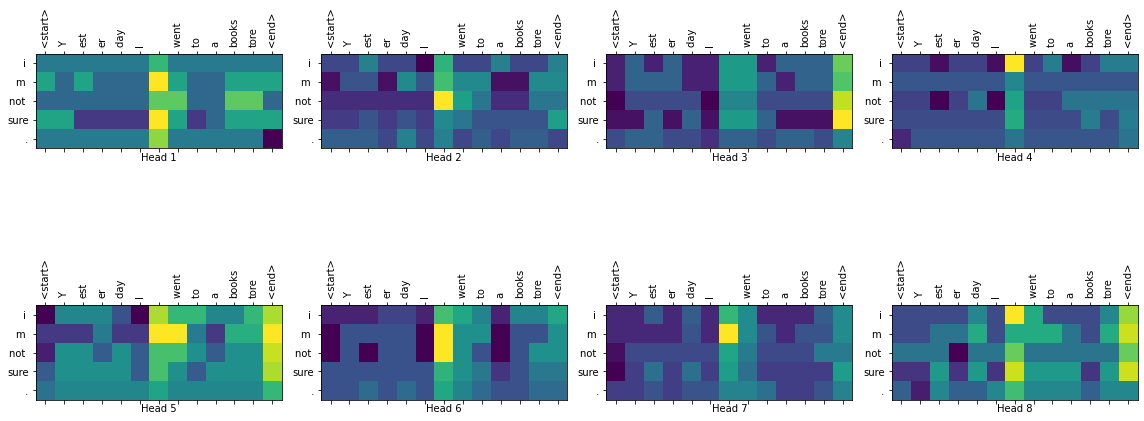

'i m not sure .'

In [72]:
chatbot("Yesterday I went to a bookstore",plot='decoder_layer4_block2')

In [73]:
chatbot("Yesterday I went to a bookstore")

Input: Yesterday I went to a bookstore
Predicted Response: i m not sure .


'i m not sure .'

In [74]:
chatbot("who are you?")

Input: who are you?
Predicted Response: i m not sure .


'i m not sure .'

In [75]:
# feed the model with its previous output
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
  sentence = chatbot(sentence)
  print('')

Input: I am not crazy, my mother had me tested.
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .



In [76]:
# feed the model with its previous output
sentence = 'Who are you?'
for _ in range(5):
  sentence = chatbot(sentence)
  print('')

Input: Who are you?
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .



In [77]:
bleuplus = 0

for ques_, ans_ in zip(questions_val,answers_val):
    predicted = chatbot(ques_)
    print('Real Response: {}'.format(ans_))
    bleu_ = bleu.sentence_bleu([ans_.split()], predicted.split())
    print("BLEU Score: ", bleu_)
    print("----" *20)

    bleuplus += bleu_

Input: what is it , son ?
Predicted Response: i m not sure .
Real Response: two more hogs got the fever .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------


C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

Input: who s he ?
Predicted Response: i m not sure .
Real Response: best we move that pig .
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: hullo , paw .
Predicted Response: i m not sure .
Real Response: i guess you lost some hogs to the fever .
BLEU Score:  5.330020010319017e-232
--------------------------------------------------------------------------------
Input: i guess you lost some hogs to the fever .
Predicted Response: i m not sure .
Real Response: three .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: three .
Predicted Response: i m not sure .
Real Response: three ? that ain t bad considerin .
BLEU Score:  6.686350417856737e-232
--------------------------------------------------------------------------------
Input: that fella come by . . . tom .
Predicted Response: i m not sure .
Real Response: tom ?
BLEU Score:  0
----------

Input: see that scrub oak yonder ?
Predicted Response: i m not sure .
Real Response: fuck you .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: fuck you .
Predicted Response: i m not sure .
Real Response: he s blind , for chri . . .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: he s blind , for chri . . .
Predicted Response: i m not sure .
Real Response: i ain t blind , you asshole .
BLEU Score:  7.951455490316087e-232
--------------------------------------------------------------------------------
Input: say , ned . . . ?
Predicted Response: i m not sure .
Real Response: yeah .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: yeah .
Predicted Response: i m not sure .
Real Response: how many men you killed ? ain t you gonna answer ?
BLEU Score:  0
-----------

Input: i told you i m a damn killer . i done it before . i m more killer than him .
Predicted Response: i m not sure .
Real Response: yeah ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: yeah ?
Predicted Response: i m not sure .
Real Response: hell , yeah .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: jack . what are you doing here ?
Predicted Response: i m not sure .
Real Response: i ve been looking all over for you . you still after the coke that walked out of that blood bath in the harbor ?
BLEU Score:  2.6536607065583572e-233
--------------------------------------------------------------------------------
Input: i ve been looking all over for you . you still after the coke that walked out of that blood bath in the harbor ?
Predicted Response: i m not sure .
Real Response: yeah .
BLEU Score:  1.2183324802375697e-231
--------------------------------

Input: edie , please . i don t want to hear this right now . what did renault and fortier say ?
Predicted Response: i m not sure .
Real Response: they want more time to think about investing .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: they want more time to think about investing .
Predicted Response: i m not sure .
Real Response: goddamnit .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: goddamnit .
Predicted Response: i m not sure .
Real Response: they just said they wanted time .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: they just said they wanted time .
Predicted Response: i m not sure .
Real Response: time for what , edie ? time to look into me a little more , that s what . no matter how well you cover my tracks now , they ll find out who i am 

Input: then who goes ?
Predicted Response: i m not sure .
Real Response: we all go . how about it , keaton ?
BLEU Score:  4.481994719908145e-232
--------------------------------------------------------------------------------
Input: don t move , you fuckers .
Predicted Response: i m not sure .
Real Response: right there . freeze .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: everybody i ever worked with , did time with .
Predicted Response: i m not sure .
Real Response: they fucking know everything .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: it s bullshit . this guy could be l . a . p . d . i think it s a setup .
Predicted Response: i m not sure .
Real Response: the way i hear it , soze is some kind of butcher . no pity .
BLEU Score:  1.6053711764843032e-232
--------------------------------------------------------------------

Input: you watch your mouth .
Predicted Response: i m not sure .
Real Response: okay , okay . you say it s the real thing ? that s cool .
BLEU Score:  1.3499508674573843e-232
--------------------------------------------------------------------------------
Input: i was out of line .
Predicted Response: i m not sure .
Real Response: you okay ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: you okay ?
Predicted Response: i m not sure .
Real Response: i be alright .
BLEU Score:  1.4488496539373276e-231
--------------------------------------------------------------------------------
Input: i be alright .
Predicted Response: i m not sure .
Real Response: well , i m sorry .
BLEU Score:  7.600394483915427e-155
--------------------------------------------------------------------------------
Input: well , i m sorry .
Predicted Response: i m not sure .
Real Response: forget it . i probably shit blood tonight .
BLEU Score:  6.510101141652543e

Input: what about redfoot ?
Predicted Response: i m not sure .
Real Response: mr . redfoot knew nothing . mr . soze rarely t works with the same people for very long , and they never know who they re working for . one cannot be betrayed if one has no people .
BLEU Score:  1.110975416777944e-234
--------------------------------------------------------------------------------
Input: the answer is no .
Predicted Response: i m not sure .
Real Response: mr . soze will be most
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: mr . soze will be most
Predicted Response: i m not sure .
Real Response: listen to me , cocksucker . there is no keyser sate . if you say his name again , i kill you right here .
BLEU Score:  2.6536607065583572e-233
--------------------------------------------------------------------------------
Input: listen to me , cocksucker . there is no keyser sate . if you say his name again , i kill you righ

Input: someplace else , then .
Predicted Response: i m not sure .
Real Response: where ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i know what i wanted to know about keaton .
Predicted Response: i m not sure .
Real Response: which is shit .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: which is shit .
Predicted Response: i m not sure .
Real Response: no matter . he ll have to know how close we came .
BLEU Score:  2.459770855197576e-232
--------------------------------------------------------------------------------
Input: no matter . he ll have to know how close we came .
Predicted Response: i m not sure .
Real Response: keyser sate or not , if keaton s alive he ll never come up again .
BLEU Score:  1.6053711764843032e-232
--------------------------------------------------------------------------------
Input: keyser sate or not , if keaton s alive 

Input: you know ruby is in attica ?
Predicted Response: i m not sure .
Real Response: he didn t have my lawyer .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: he didn t have my lawyer .
Predicted Response: i m not sure .
Real Response: i know ruby . he s very big on respect . likes me very much .
BLEU Score:  1.6053711764843032e-232
--------------------------------------------------------------------------------
Input: there s nothing in there about ruby .
Predicted Response: i m not sure .
Real Response: i be sure to mention that to him .
BLEU Score:  7.204611228887491e-232
--------------------------------------------------------------------------------
Input: the first thing i learned on the job , know what it was ? how to spot a murderer . let s say you arrest three guys for the same killing . put them all in jail overnight . the next morning , whoever is sleeping is your man . if you re guilty , you know 

Input: so this lawyer . . .
Predicted Response: i m not sure .
Real Response: kobayashi .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: kobayashi .
Predicted Response: i m not sure .
Real Response: came from redfoot .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: came from redfoot .
Predicted Response: i m not sure .
Real Response: right .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: right .
Predicted Response: i m not sure .
Real Response: and why leave this out when you talked to the d . a . ?
BLEU Score:  1.6488337128931635e-232
--------------------------------------------------------------------------------
Input: do you believe in him , verbal ?
Predicted Response: i m not sure .
Real Response: keaton always said quot i don t believe in god , but 

Input: wait a minute .
Predicted Response: i m not sure .
Real Response: i don t have a minute . are you saying it was keyser soze ? you told the d . a . you didn t know who it was .
BLEU Score:  9.762272177873033e-234
--------------------------------------------------------------------------------
Input: don t shine me , verbal . no more stalling . you know what i m getting at .
Predicted Response: i m not sure .
Real Response: i don t .
BLEU Score:  1.4488496539373276e-231
--------------------------------------------------------------------------------
Input: i don t .
Predicted Response: i m not sure .
Real Response: yes you do . you know what i m getting at . the truth . try to tell me you didn t know . try to tell me you saw someone kill keaton .
BLEU Score:  2.8105222993027868e-157
--------------------------------------------------------------------------------
Input: try to reef lying to me now . i know everything .
Predicted Response: i m not sure .
Real Response: i don t know 

Input: this is all bullshit .
Predicted Response: i m not sure .
Real Response: he left you to stay behind and tell us he was dead . you saw him die , right ? or did you ? you had to hide when the first police cars showed up . you heard the shot , just before the fire but you didn t see him die .
BLEU Score:  8.251611951225883e-236
--------------------------------------------------------------------------------
Input: he left you to stay behind and tell us he was dead . you saw him die , right ? or did you ? you had to hide when the first police cars showed up . you heard the shot , just before the fire but you didn t see him die .
Predicted Response: i m not sure .
Real Response: i knew him . he would never
BLEU Score:  9.711929667259895e-232
--------------------------------------------------------------------------------
Input: i knew him . he would never
Predicted Response: i m not sure .
Real Response: he programmed you to tell us just what he wanted you to . customs has been
BLEU 

Input: mr . abraham . . .
Predicted Response: i m not sure .
Real Response: abrams . . .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: abrams . . .
Predicted Response: i m not sure .
Real Response: abrams . yes . how are you today ?
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: abrams . yes . how are you today ?
Predicted Response: i m not sure .
Real Response: i m fine .
BLEU Score:  9.283142785759642e-155
--------------------------------------------------------------------------------
Input: i m fine .
Predicted Response: i m not sure .
Real Response: good . you ever been inside a hospital ?
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: good . you ever been inside a hospital ?
Predicted Response: i m not sure .
Real Response: yes .
BLEU Score:  1.218332

Input: we thought it was just .
Predicted Response: i m not sure .
Real Response: you thought it was just .
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: you thought it was just .
Predicted Response: i m not sure .
Real Response: yes .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: yes .
Predicted Response: i m not sure .
Real Response: because it struck me how neatly three went into the amount . two hundred ten thousand . that would mean i keep seventy .
BLEU Score:  3.241188506211644e-233
--------------------------------------------------------------------------------
Input: because it struck me how neatly three went into the amount . two hundred ten thousand . that would mean i keep seventy .
Predicted Response: i m not sure .
Real Response: that was our insurance company s recommendation .
BLEU Score:  6.686350417856737e-232
----

Input: you were there to help dr . marx deliver her baby . were you not ?
Predicted Response: i m not sure .
Real Response: yes .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: anything special about the case ?
Predicted Response: i m not sure .
Real Response: when she . . .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: thank you . when debby . . .
Predicted Response: i m not sure .
Real Response: dr . towler , who was in the operating room with you ?
BLEU Score:  2.459770855197576e-232
--------------------------------------------------------------------------------
Input: dr . towler , who was in the operating room with you ?
Predicted Response: i m not sure .
Real Response: ms . nevins , nurse anesthetist dr . marx , of course . . .
BLEU Score:  1.6488337128931635e-232
-------------------------------------------------------------

Input: dr . thompson , just so the jury knows , you never treated deborah ann kaye . is that correct ?
Predicted Response: i m not sure .
Real Response: that is correct . i was engaged to render an opinion .
BLEU Score:  3.572819258687922e-232
--------------------------------------------------------------------------------
Input: that is correct . i was engaged to render an opinion .
Predicted Response: i m not sure .
Real Response: engaged to render an opinion . for a price . is that correct ? you re being paid to be here today ?
BLEU Score:  3.3289378538532914e-233
--------------------------------------------------------------------------------
Input: engaged to render an opinion . for a price . is that correct ? you re being paid to be here today ?
Predicted Response: i m not sure .
Real Response: just as you are , sir . . .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: just as you are , sir . . .
Predicte

Input: nothing further , your honor .
Predicted Response: i m not sure .
Real Response: mr . galvin , rebuttal ?
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: objection ! this is ri . . . expect us to accept a photocopy , we have the original right . . .
Predicted Response: i m not sure .
Real Response: i ll rule on that presently . proceed .
BLEU Score:  6.510101141652543e-232
--------------------------------------------------------------------------------
Input: no further questions .
Predicted Response: i m not sure .
Real Response: you may step down .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: thank you , your honor . we object to the copy of the admissions form as incompetemt and essentially hearsay evidence and cite mcgee versus state of indiana , u . s . point and through of the uniform code the admission of a duplicate do

Input: i do . yes .
Predicted Response: i m not sure .
Real Response: you swore on this form that the patient ate nine hours ago .
BLEU Score:  2.459770855197576e-232
--------------------------------------------------------------------------------
Input: you swore on this form that the patient ate nine hours ago .
Predicted Response: i m not sure .
Real Response: that s not my handwriting .
BLEU Score:  1.1862177682648818e-231
--------------------------------------------------------------------------------
Input: that s not my handwriting .
Predicted Response: i m not sure .
Real Response: you ve just said you signed it .
BLEU Score:  6.686350417856737e-232
--------------------------------------------------------------------------------
Input: you ve just said you signed it .
Predicted Response: i m not sure .
Real Response: yes , i , yes , i signed it , yes . but i , i didn t write that figure .
BLEU Score:  4.835285063277543e-233
------------------------------------------------------

Input: if i could accept the offer right now , i would . they took it back .
Predicted Response: i m not sure .
Real Response: i understand . i went to the bar association . they tell me you re going to be disbarred .
BLEU Score:  7.213397677533374e-233
--------------------------------------------------------------------------------
Input: they gave her the wrong anesthetic .
Predicted Response: i m not sure .
Real Response: why is that ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: why is that ?
Predicted Response: i m not sure .
Real Response: her sister said she ate one hour prior to admittance . . . she . . .
BLEU Score:  1.1052462903316595e-232
--------------------------------------------------------------------------------
Input: her sister said she ate one hour prior to admittance . . . she . . .
Predicted Response: i m not sure .
Real Response: . . . that s what the sister said . the chart said she ate nine hours prior t

Input: . . . apartment . no , no . please . you don t know who we re dealing with , i , please believe me , they . . .
Predicted Response: i m not sure .
Real Response: . . . what difference would . . .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: . . . what difference would . . .
Predicted Response: i m not sure .
Real Response: these people play very rough . they don t want to lose this case . there s a lot of pressure they can bring to bear , i . . .
BLEU Score:  7.992672451942217e-234
--------------------------------------------------------------------------------
Input: these people play very rough . they don t want to lose this case . there s a lot of pressure they can bring to bear , i . . .
Predicted Response: i m not sure .
Real Response: there s nothing they can do to me .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: dr 

Input: they called , they re going to settle , what i want to do is build up as much . . .
Predicted Response: i m not sure .
Real Response: right . who called ?
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: right . who called ?
Predicted Response: i m not sure .
Real Response: the archdiocese called , they want to settle . . . her estate . . .
BLEU Score:  1.3499508674573843e-232
--------------------------------------------------------------------------------
Input: the archdiocese called , they want to settle . . . her estate . . .
Predicted Response: i m not sure .
Real Response: . . . and you re going to do that ?
BLEU Score:  3.6695469123219324e-232
--------------------------------------------------------------------------------
Input: . . . and you re going to do that ?
Predicted Response: i m not sure .
Real Response: yes .
BLEU Score:  1.2183324802375697e-231
-----------------------------------------

Input: i want someone who was in the o . r . we re going to win the case , there s no question of that . it s just a matter of how big . . .
Predicted Response: i m not sure .
Real Response: i ve got nothing to say to you .
BLEU Score:  6.510101141652543e-232
--------------------------------------------------------------------------------
Input: i ve got nothing to say to you .
Predicted Response: i m not sure .
Real Response: you know what happened .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: you know what happened .
Predicted Response: i m not sure .
Real Response: nothing happened .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: nothing happened .
Predicted Response: i m not sure .
Real Response: then why aren t you testifying for their side ?
BLEU Score:  0
--------------------------------------------------------------------

Input: thank you for seeing me .
Predicted Response: i m not sure .
Real Response: that s perfectly all right .
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: i need an extension for my case .
Predicted Response: i m not sure .
Real Response: you should have taken their offer . especially if you were unprepared .
BLEU Score:  2.459770855197576e-232
--------------------------------------------------------------------------------
Input: you should have taken their offer . especially if you were unprepared .
Predicted Response: i m not sure .
Real Response: i had a witness disappear on me .
BLEU Score:  7.951455490316087e-232
--------------------------------------------------------------------------------
Input: i had a witness disappear on me .
Predicted Response: i m not sure .
Real Response: that happens .
BLEU Score:  1.2183324802375697e-231
---------------------------------------------------------------------

Input: business hours are over , sir . this is the switch . . .
Predicted Response: i m not sure .
Real Response: i have to reach him . this is an emergency . could you give me his home number ?
BLEU Score:  8.810463819045427e-233
--------------------------------------------------------------------------------
Input: i have to reach him . this is an emergency . could you give me his home number ?
Predicted Response: i m not sure .
Real Response: i m sorry , sir , we re not allowed . . .
BLEU Score:  2.013995721342433e-155
--------------------------------------------------------------------------------
Input: i m sorry , sir , we re not allowed . . .
Predicted Response: i m not sure .
Real Response: . . . would you , would you call him up . i ll give you my number , and ask him . . .
BLEU Score:  2.6536607065583572e-233
--------------------------------------------------------------------------------
Input: . . . would you , would you call him up . i ll give you my number , and ask him .

Input: yes . it was , actually .
Predicted Response: i m not sure .
Real Response: oh , actually it was . then why d you call it off ?
BLEU Score:  2.0138900446751835e-232
--------------------------------------------------------------------------------
Input: oh , actually it was . then why d you call it off ?
Predicted Response: i m not sure .
Real Response: who says i m the one that called it off ?
BLEU Score:  2.5264972939852307e-155
--------------------------------------------------------------------------------
Input: who says i m the one that called it off ?
Predicted Response: i m not sure .
Real Response: a brick house says you divorced him . i ll put you on your honor . bet you a hundred dollars against you join me for dinner . and i ll take your word for it . now you tell me the truth . because you cannot lie to me . what s your name ?
BLEU Score:  5.3854203362237196e-236
--------------------------------------------------------------------------------
Input: a brick house say

Input: isn t there something you . . .
Predicted Response: i m not sure .
Real Response: that s not the question . it s over . do you think that it s my fault ? if i d . . . if i d . . . i never should have taken it . there was no way that i was going to win .
BLEU Score:  2.416877815858541e-235
--------------------------------------------------------------------------------
Input: that s not the question . it s over . do you think that it s my fault ? if i d . . . if i d . . . i never should have taken it . there was no way that i was going to win .
Predicted Response: i m not sure .
Real Response: you re talking like a drunk .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: you re talking like a drunk .
Predicted Response: i m not sure .
Real Response: that s what i am .
BLEU Score:  1.1862177682648818e-231
--------------------------------------------------------------------------------
Input: and it s over .

Input: dr . gruber .
Predicted Response: i m not sure .
Real Response: dr . gruber s not in .
BLEU Score:  9.711929667259895e-232
--------------------------------------------------------------------------------
Input: dr . gruber s not in .
Predicted Response: i m not sure .
Real Response: i had an appointment at his office , i think i must have got it wrong . we had a meeting . . .
BLEU Score:  3.241188506211644e-233
--------------------------------------------------------------------------------
Input: i had an appointment at his office , i think i must have got it wrong . we had a meeting . . .
Predicted Response: i m not sure .
Real Response: he s not in , sir .
BLEU Score:  9.711929667259895e-232
--------------------------------------------------------------------------------
Input: he s not in , sir .
Predicted Response: i m not sure .
Real Response: where is he ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i . . . please

Input: i know what i said but not now . you won it . franky . you won it . when they give you the money , that means that you won . we don t want to go to court is this getting to you . . . ? you know who the attorney is for the archdiocese , eddie concannon .
Predicted Response: i m not sure .
Real Response: . . . he s a good man . . .
BLEU Score:  3.6695469123219324e-232
--------------------------------------------------------------------------------
Input: . . . he s a good man . . .
Predicted Response: i m not sure .
Real Response: . . . he s a good man . . . ? he s the prince of fuckin darkness . . . he ll have people in there testifying that the broad is well they saw her tuesday on a surfboard at hyannis . . . don t fuck with this case .
BLEU Score:  8.251611951225883e-236
--------------------------------------------------------------------------------
Input: . . . he s a good man . . . ? he s the prince of fuckin darkness . . . he ll have people in there testifying that the bro

Input: so what ?
Predicted Response: i m not sure .
Real Response: so what . . . ? the best is yet to come . check the tv guide . they got our dr . towler on a panel on gbh on friday the healing hand . the experts speak .
BLEU Score:  1.356948438300725e-234
--------------------------------------------------------------------------------
Input: so what . . . ? the best is yet to come . check the tv guide . they got our dr . towler on a panel on gbh on friday the healing hand . the experts speak .
Predicted Response: i m not sure .
Real Response: they still have to take it to a jury .
BLEU Score:  4.481994719908145e-232
--------------------------------------------------------------------------------
Input: what i m saying , they re getting some help .
Predicted Response: i m not sure .
Real Response: so what do you want me to do ? concannon s going to try the case his way , i m going to try it mine . you want me to go wee wee wee all the time because he s got some flack , got stories in 

Input: the history . . . ?
Predicted Response: i m not sure .
Real Response: how old are you , how many children . . . when did you last eat . . .
BLEU Score:  7.408687442158376e-233
--------------------------------------------------------------------------------
Input: we don t have anything from the nurse association ?
Predicted Response: i m not sure .
Real Response: the broad has disappeared . . .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: the broad has disappeared . . .
Predicted Response: i m not sure .
Real Response: the hospital . . . ?
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: . . . yeah . . . good . . .
Predicted Response: i m not sure .
Real Response: . . . you need some old forms that she had . . . somebody s dying . . .
BLEU Score:  6.065720248837714e-233
-----------------------------------------------------------

Input: we , yes . yes . they , they present their side , and i get the same chance . to cross examine . . . to . . . to . . .
Predicted Response: i m not sure .
Real Response: are we going to win ? we have , you know , other tactics , though . . .
BLEU Score:  7.408687442158376e-233
--------------------------------------------------------------------------------
Input: are we going to win ? we have , you know , other tactics , though . . .
Predicted Response: i m not sure .
Real Response: yes .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: i spoke to her , and everything is all right .
Predicted Response: i m not sure .
Real Response: i , what are you talking about ? i talked to her this morning , and she said . . .
BLEU Score:  5.905830512777864e-233
--------------------------------------------------------------------------------
Input: i , what are you talking about ? i talked to her this morning , and she

Input: another , frank . . . ?
Predicted Response: i m not sure .
Real Response: . . . everybody . mike says , pat , you mean to tell me for a buck you get a free lunch and a beer , and then you go in the back and get laid ? that s correct . mike says , pat . have you been in this bar ? pat says , no , but my sister has . . . everyone . buy yourself one too .
BLEU Score:  1.511335447486165e-237
--------------------------------------------------------------------------------
Input: i want to buy you a drink .
Predicted Response: i m not sure .
Real Response: thanks , franky .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: well , well , well . huh ?
Predicted Response: i m not sure .
Real Response: yeah .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: yeah .
Predicted Response: i m not sure .
Real Response: it s a long road that has n

Input: should i ?
Predicted Response: i m not sure .
Real Response: a huge law firm . okay ? they put him in the firm , he s married , everything s superb . franky , he s starting to talk like he comes from dorsetshire , some fuckin place , you must drop by with pat and me . . . okay . . . ?
BLEU Score:  5.531220903013963e-236
--------------------------------------------------------------------------------
Input: a huge law firm . okay ? they put him in the firm , he s married , everything s superb . franky , he s starting to talk like he comes from dorsetshire , some fuckin place , you must drop by with pat and me . . . okay . . . ?
Predicted Response: i m not sure .
Real Response: yes .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: yes .
Predicted Response: i m not sure .
Real Response: . . . and he s making a billion dollars every minute working for stearns , harrington , and he bought a dog , and everyth

Input: and you like it .
Predicted Response: i m not sure .
Real Response: san francisco s changed . the things a that spell san francisco to me are disappearing fast .
BLEU Score:  9.048991276198851e-233
--------------------------------------------------------------------------------
Input: like all this .
Predicted Response: i m not sure .
Real Response: i d like to have lived here then . the color and excitement . . . the power . . . the freedom .
BLEU Score:  3.241188506211644e-233
--------------------------------------------------------------------------------
Input: shouldn t you be sitting down ?
Predicted Response: i m not sure .
Real Response: no , i m all right .
BLEU Score:  6.222676699505816e-155
--------------------------------------------------------------------------------
Input: no , i m all right .
Predicted Response: i m not sure .
Real Response: i was sorry to read about that thing in the papers . and you ve quit the force . a permanent physical disability ?
BLEU Sco

Input: have you talked to the doctors at all ?
Predicted Response: i m not sure .
Real Response: yes , but carefully . i d want to know more before committing her to that kind of care . scottie
BLEU Score:  5.905830512777864e-233
--------------------------------------------------------------------------------
Input: yes , but carefully . i d want to know more before committing her to that kind of care . scottie
Predicted Response: i m not sure .
Real Response: i can get you a firm of private eyes to follow her for you . they re dependable , good boys
BLEU Score:  5.905830512777864e-233
--------------------------------------------------------------------------------
Input: i can get you a firm of private eyes to follow her for you . they re dependable , good boys
Predicted Response: i m not sure .
Real Response: i want you .
BLEU Score:  1.4488496539373276e-231
--------------------------------------------------------------------------------
Input: i want you .
Predicted Response: i m no

Input: hello .
Predicted Response: i m not sure .
Real Response: scottie , what happened ? she s not home , yet .
BLEU Score:  3.572819258687922e-232
--------------------------------------------------------------------------------
Input: scottie , what happened ? she s not home , yet .
Predicted Response: i m not sure .
Real Response: no , she s all right . she s still here . but i ll get her home soon .
BLEU Score:  7.213397677533374e-233
--------------------------------------------------------------------------------
Input: no , she s all right . she s still here . but i ll get her home soon .
Predicted Response: i m not sure .
Real Response: what happened ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: what happened ?
Predicted Response: i m not sure .
Real Response: she . . . went into the bay .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: hello ?


Input: but before ! where did you live before ! ? !
Predicted Response: i m not sure .
Real Response: salina , kansas !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: listen , what is this ? what do you want ?
Predicted Response: i m not sure .
Real Response: i want to know who you are .
BLEU Score:  7.951455490316087e-232
--------------------------------------------------------------------------------
Input: i want to know who you are .
Predicted Response: i m not sure .
Real Response: i told you ! my name is judy barton ! i come from salina kansas . i work at magnin s ! i live here ! my gosh , do i have to prove it ?
BLEU Score:  2.940339875086885e-234
--------------------------------------------------------------------------------
Input: will you have dinner with me ?
Predicted Response: i m not sure .
Real Response: why ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: why

Input: no , judy , i m not going to move ! please ! stay in the chair !
Predicted Response: i m not sure .
Real Response: why ? !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: why ? !
Predicted Response: i m not sure .
Real Response: please ! and don t look at me .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: will you , judy ?
Predicted Response: i m not sure .
Real Response: i suppose i could phone the store in the morning , and say i m sick .
BLEU Score:  8.421477136174899e-156
--------------------------------------------------------------------------------
Input: i like that one .
Predicted Response: i m not sure .
Real Response: no , there . there s a good one . do you like that ?
BLEU Score:  1.6488337128931635e-232
--------------------------------------------------------------------------------
Input: no , there . there s a good one . do you like

Input: wherever you d like . . .
Predicted Response: i m not sure .
Real Response: ernie s ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: ernie s ?
Predicted Response: i m not sure .
Real Response: you ve got a thing about ernie s , haven t you ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: you ve got a thing about ernie s , haven t you ?
Predicted Response: i m not sure .
Real Response: well , after all , it s our place .
BLEU Score:  4.481994719908145e-232
--------------------------------------------------------------------------------
Input: mmmm .
Predicted Response: i m not sure .
Real Response: is that the best you can do ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: come here .
Predicted Response: i m not sure .
Real Response: oh , no . you ll muss me .
BLEU Score:  5.474320712955125e-232
------------------

Input: but you knew , that day , that i wouldn t be able to follow you didn t you . who was at the top when you got there ? elster ? with his wife ?
Predicted Response: i m not sure .
Real Response: yes !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: yes !
Predicted Response: i m not sure .
Real Response: and she was the one who died . not you . the real wife . you were the copy , you were the counterfeit . was she dead or alive when you got there ?
BLEU Score:  3.591339233359451e-234
--------------------------------------------------------------------------------
Input: and she was the one who died . not you . the real wife . you were the copy , you were the counterfeit . was she dead or alive when you got there ?
Predicted Response: i m not sure .
Real Response: dead . he d broken her neck .
BLEU Score:  6.686350417856737e-232
--------------------------------------------------------------------------------
Input: dead . he d br

Input: where had you been before ?
Predicted Response: i m not sure .
Real Response: when ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: when ?
Predicted Response: i m not sure .
Real Response: this afternoon .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: this afternoon .
Predicted Response: i m not sure .
Real Response: oh . . . wandering about .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: oh . . . wandering about .
Predicted Response: i m not sure .
Real Response: before ? where ? where had you been ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: please drink your coffee .
Predicted Response: i m not sure .
Real Response: i will . you re terribly direct in your questions .
BLEU Score:  4.3638512969692e-232
-------

Input: good morning . i worried about you , last night . you shouldn t have run like that .
Predicted Response: i m not sure .
Real Response: i . . . suddenly felt such a fool .
BLEU Score:  5.330020010319017e-232
--------------------------------------------------------------------------------
Input: i . . . suddenly felt such a fool .
Predicted Response: i m not sure .
Real Response: i wanted to drive you home . are you all right ?
BLEU Score:  3.572819258687922e-232
--------------------------------------------------------------------------------
Input: i wanted to drive you home . are you all right ?
Predicted Response: i m not sure .
Real Response: oh , yes . fine . no after effects . but as i remember now , that water was cold , wasn t it ? what a terrible thing to do . . . and you were so kind . . . it s a formal thank you letter . and a great big apology .
BLEU Score:  5.3854203362237196e-236
--------------------------------------------------------------------------------
Input: 

Input: only silence . it s always like this .
Predicted Response: i m not sure .
Real Response: and no birds sing .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: and no birds sing .
Predicted Response: i m not sure .
Real Response: no birds live here .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: no birds live here .
Predicted Response: i m not sure .
Real Response: no .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: would you like a drink of water ?
Predicted Response: i m not sure .
Real Response: no , thank you .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: somewhere in here i was born . . . and here i died and it was only a moment for you . . . you took no notice . . .
P

Input: how do you know ?
Predicted Response: i m not sure .
Real Response: i know .
BLEU Score:  1.4488496539373276e-231
--------------------------------------------------------------------------------
Input: i know .
Predicted Response: i m not sure .
Real Response: there s a name on the gravestone .
BLEU Score:  6.686350417856737e-232
--------------------------------------------------------------------------------
Input: there s a name on the gravestone .
Predicted Response: i m not sure .
Real Response: no . it s new and clean , and waiting .
BLEU Score:  3.6695469123219324e-232
--------------------------------------------------------------------------------
Input: no . it s new and clean , and waiting .
Predicted Response: i m not sure .
Real Response: what else ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: what else ?
Predicted Response: i m not sure .
Real Response: this part is dream , i think . there is a tower and a be

Input: go on with your dream . what was it that frightened you ?
Predicted Response: i m not sure .
Real Response: i stood alone on the green , searching for something , and i started to walk to the church . but then the darkness closed in , i was alone in the dark , being pulled into darkness , and i fought to wake up . . .
BLEU Score:  2.6674161544312916e-235
--------------------------------------------------------------------------------
Input: here with you .
Predicted Response: i m not sure .
Real Response: and it s a all real .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: and it s a all real .
Predicted Response: i m not sure .
Real Response: yes .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: yes .
Predicted Response: i m not sure .
Real Response: not merely as it was a hundred years ago . as it was a year ago , or six mont

Input: carlotta valdes ?
Predicted Response: i m not sure .
Real Response: yes , that s it . sweet name , isn t it ? foreign . but sweet .
BLEU Score:  9.048991276198851e-233
--------------------------------------------------------------------------------
Input: yes , that s it . sweet name , isn t it ? foreign . but sweet .
Predicted Response: i m not sure .
Real Response: how long has she had the room ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: how long has she had the room ?
Predicted Response: i m not sure .
Real Response: oh , it must be two weeks . yes , the rent s due tomorrow .
BLEU Score:  1.3499508674573843e-232
--------------------------------------------------------------------------------
Input: oh , it must be two weeks . yes , the rent s due tomorrow .
Predicted Response: i m not sure .
Real Response: does she sleep here ? ever ?
BLEU Score:  0
-------------------------------------------------------------------

Input: i know . i have acrophobia . what a disease . a fear of heights . and what a moment to find out i had it .
Predicted Response: i m not sure .
Real Response: well , you ve got it . and there s no losing it . and there s no one to blame . so why quit ?
BLEU Score:  1.826959830028561e-233
--------------------------------------------------------------------------------
Input: well , you ve got it . and there s no losing it . and there s no one to blame . so why quit ?
Predicted Response: i m not sure .
Real Response: and sit behind a desk ? chairborne ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: and sit behind a desk ? chairborne ?
Predicted Response: i m not sure .
Real Response: it s where you belong .
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: it s where you belong .
Predicted Response: i m not sure .
Real Response: not with my acrophobia , m

Input: he s probably on the bum and wants to touch you for the price of a drink .
Predicted Response: i m not sure .
Real Response: well , i m on the bum i ll buy him a couple of drinks and tell him my troubles . but not tonight . if you won t drink with me , i ll drink alone , tonight .
BLEU Score:  9.096374693518689e-158
--------------------------------------------------------------------------------
Input: well , i m on the bum i ll buy him a couple of drinks and tell him my troubles . but not tonight . if you won t drink with me , i ll drink alone , tonight .
Predicted Response: i m not sure .
Real Response: sorry , old man . work .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: sorry , old man . work .
Predicted Response: i m not sure .
Real Response: midge , what did you mean , there s no losing it ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: mi

Input: you ll tell , or you ll be back in that corset ! come on !
Predicted Response: i m not sure .
Real Response: i ll take you home .
BLEU Score:  1.1862177682648818e-231
--------------------------------------------------------------------------------
Input: here you are .
Predicted Response: i m not sure .
Real Response: you haven t told me everything .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: you haven t told me everything .
Predicted Response: i m not sure .
Real Response: i ve told you enough .
BLEU Score:  1.1862177682648818e-231
--------------------------------------------------------------------------------
Input: i ve told you enough .
Predicted Response: i m not sure .
Real Response: who s the guy , who s the wife ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: who s the guy , who s the wife ?
Predicted Response: i m not sure .
Real Res

Input: well , it s a living . but i m excited about this .
Predicted Response: i m not sure .
Real Response: what is it , a still life ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: what is it , a still life ?
Predicted Response: i m not sure .
Real Response: no , not exactly . want to see ?
BLEU Score:  6.510101141652543e-232
--------------------------------------------------------------------------------
Input: as a matter of fact , i thought i might give it to you .
Predicted Response: i m not sure .
Real Response: oh ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: yes . . . the beautiful carlotta . . . the sad carlotta . . .
Predicted Response: i m not sure .
Real Response: what does a big old wooden house on the corner of eddy and gough street have to do with her ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: w

Input: no first of all . i m not in a game mood .
Predicted Response: i m not sure .
Real Response: you re interrupting a personal conversation .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: you re interrupting a personal conversation .
Predicted Response: i m not sure .
Real Response: sorry fish .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: it s really a stupid opinion . you have developed an annoying habit of talking for what seems to be no other reason than to hear yourself speak .
Predicted Response: i m not sure .
Real Response: because my opinion threatens yours , it s poorly developed ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: because my opinion threatens yours , it s poorly developed ?
Predicted Response: i m not sure .
Real Response: no , because your opinion

Input: don t you fucking threaten me i ll fucking kill you .
Predicted Response: i m not sure .
Real Response: go home !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: go home !
Predicted Response: i m not sure .
Real Response: you go home !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: four hours and fifteen minutes . i can make vegas in and change .
Predicted Response: i m not sure .
Real Response: i m not getting a ticket .
BLEU Score:  4.947126313800877e-78
--------------------------------------------------------------------------------
Input: don t even start .
Predicted Response: i m not sure .
Real Response: you want to hear me out ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: one idea that if you had fucking listened to , you would each be worth approximately million dollars .
Predicted Response: i m not sure

Input: have you completely lost your mind ? so you get her out of here . so you get her out into the desert somehow , without anybody seeing , so what , you don t think at some point somebody might notice that she s gone ?
Predicted Response: i m not sure .
Real Response: nobody knows she s here . i called her personally . nobody knows .
BLEU Score:  2.3949323699607068e-232
--------------------------------------------------------------------------------
Input: her blood is all over the bathroom . i d say that s a bit of a dna problem .
Predicted Response: i m not sure .
Real Response: it s a marble floor , we can clean it up .
BLEU Score:  3.00437090698032e-232
--------------------------------------------------------------------------------
Input: her fucking head was caved in .
Predicted Response: i m not sure .
Real Response: so i didn t fucking do it !
BLEU Score:  6.686350417856737e-232
--------------------------------------------------------------------------------
Input: so i did

Input: boyd you idiot , the shit s coming down !
Predicted Response: i m not sure .
Real Response: what does that mean ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: what does that mean ?
Predicted Response: i m not sure .
Real Response: you got us into this mess .
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
Input: you got us into this mess .
Predicted Response: i m not sure .
Real Response: oh i did ? i think it was your little rat fuck brother who decided to play hamburger helper with the hooker s head .
BLEU Score:  2.6536607065583572e-233
--------------------------------------------------------------------------------
Input: oh i did ? i think it was your little rat fuck brother who decided to play hamburger helper with the hooker s head .
Predicted Response: i m not sure .
Real Response: would you , shush ? ! these phones aren t secure !
BLEU Score:  0

Input: right ! that s exactly what i m saying . my father said , first of all , i m your father not your friend . i m your father .
Predicted Response: i m not sure .
Real Response: are you solid with that ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: are you solid with that ?
Predicted Response: i m not sure .
Real Response: no . i think it s fucked .
BLEU Score:  7.951455490316087e-232
--------------------------------------------------------------------------------
Input: no . i think it s fucked .
Predicted Response: i m not sure .
Real Response: then fuck what your father said , cause i m gonna tell you right now . . . you ll know what it s all about , why you got married and why you love her when you wake up at three in the morning , and the streetlight s coming through the window and it s just catching a corner of her face , like a sleeping angel . and her hair smells sweet and she s your s . she s all your s . do you see

Input: i don t understand where this personal attack is coming from . . .
Predicted Response: i m not sure .
Real Response: you re a liar . i want to know what happened in vegas .
BLEU Score:  2.3949323699607068e-232
--------------------------------------------------------------------------------
Input: you re a liar . i want to know what happened in vegas .
Predicted Response: i m not sure .
Real Response: nothing happened in vegas .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: nothing happened in vegas .
Predicted Response: i m not sure .
Real Response: i don t want to hear it from the liar . stick a plug in it boyd . fisher ? what happened in vegas ?
BLEU Score:  2.6536607065583572e-233
--------------------------------------------------------------------------------
Input: micheal ? do you have something to tell me ?
Predicted Response: i m not sure .
Real Response: micheal . tell lois that nothing . . .

In [78]:
bleuplus/1634

1.3819959811421305e-80

Input: who are you?
Predicted Response: i m not sure .


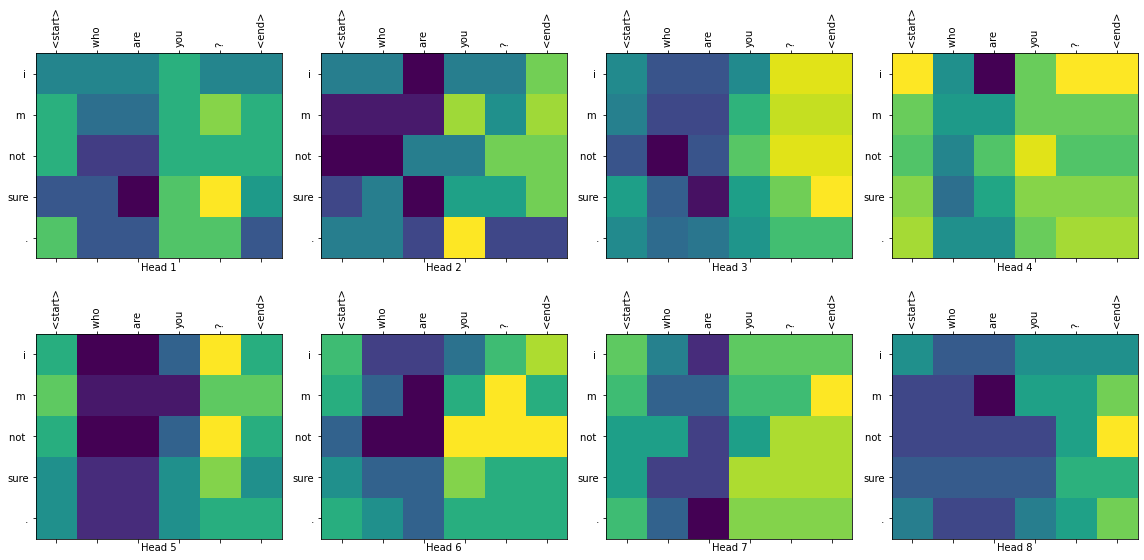

'i m not sure .'

In [79]:
chatbot("who are you?",plot='decoder_layer4_block2')

In [80]:
transformer.save_weights('/weights/chatbot_transformer_ckpt')

In [81]:
chatbot('did you finish your homework?')

Input: did you finish your homework?
Predicted Response: i m not sure .


'i m not sure .'

In [82]:
chatbot('what did you eat for breakfast?')

Input: what did you eat for breakfast?
Predicted Response: i m not sure .


'i m not sure .'

In [83]:
chatbot('how are you doing?')

Input: how are you doing?
Predicted Response: i m not sure .


'i m not sure .'

In [84]:
chatbot("What's your name?")

Input: What's your name?
Predicted Response: i m not sure .


'i m not sure .'

In [85]:
chatbot("I am hungry right now")

Input: I am hungry right now
Predicted Response: i m not sure .


'i m not sure .'

In [86]:
chatbot("I love you")

Input: I love you
Predicted Response: i m not sure .


'i m not sure .'